<a href="https://colab.research.google.com/github/O-Connor-Lab/automation/blob/main/multi_plate_luminex_analysis_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Luminex Automation (Multi plate)

# Import Packages

In [ ]:
# for importing needed packages
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
%cd '/content'

/content


#Load in Data
Indicate the number of plates you have for the assay in the numPlates variable.

In [ ]:
numPlates = 3

# Setting up varriables
data_file_path_1 = '06.15.21 K012 SIV-ZIKV Plasma Plate1.xlsx'
data_file_path_2 = '06.15.21 K012 SIV-ZIKV Plasma Plate2.xlsx'
data_file_path_3 = '06.23.21 K01 Plasma Plate 3.xlsx'

#If you have more than three plates, copy the below format and make more plate variables:
#data_file_path_x = ''

metadata_file_path = 'luminex plate maps Plasma and CSF.xlsx'

Record the number of samples on each plate in these variables with the numbers corresponding to the order you uploaded them in

In [ ]:
SampleNum1 = 40
SampleNum2 = 40
SampleNum3 =  24
#If you have more than three plates, create more variables in the same format:
#SampleNumX =

# Import raw data seperated into individual spreadsheets for each analytes
raw_data_plate_1 = pd.read_excel(data_file_path_1, sheet_name = None, header = 10, usecols = 'A:L', nrows = SampleNum1 + 9)
raw_data_plate_2 = pd.read_excel(data_file_path_2, sheet_name = None, header = 10, usecols = 'A:L', nrows = SampleNum2 + 9)
raw_data_plate_3 = pd.read_excel(data_file_path_3, sheet_name = None, header = 10, usecols = 'A:L', nrows = SampleNum3 + 9)

#If you have more than three plates, copy the below format and make more plate variables:
#raw_data_plate_x = pd.read_excel(data_file_path_X, sheet_name = None, header = 10, usecols = 'A:L', nrows = SampleNumX + 9)

#If you have more than three plates, input another term into the dictionary betwee the brackets below with the template
#"Plate X": raw_data_plate_X
raw_data = {"Plate 1": raw_data_plate_1, "Plate 2": raw_data_plate_2, "Plate 3": raw_data_plate_3}

# Import metadata with sample numbers corresponding to raw data
metadata = pd.read_excel(metadata_file_path, header = 0, usecols = 'A:E')

# Analytes
analytes = raw_data_plate_1.keys()

#Functions

In [ ]:
# Function to input the upper and lower limits of the assay into values above or below the limit of detection
# @para:
    #conc - the observed concentration
    #range_value - the designation if it is above or below the limit of detection
    #limitsOfDetection - list of the limits of detection for each analyte
    #key - analyte of intrest
# returns a concentration value
def replace_limits(conc, range_value, limitsOfDetection, key):
    if range_value == "OOR <":
        return limitsofDetection['lower kit'][key]
    elif range_value == "OOR >":
        return limitsofDetection['upper kit'][key]
    else:
        return conc

#Change limit of detection decider

In [ ]:
def extract_limits(key):
    upperLimitsOfDetection = [key]
    lowerLimitsOfDetection = [key]
    for plate in raw_data.keys():

        standards = raw_data[plate][key]["Conc in Range"][1:8].dropna() #selects out the standard values from spreadsheet

        standards2 = [num for num in standards if isinstance(num,(float))] #selects the standard values that are in the detectable range of the assay

        upperLimitsOfDetection.append(max(standards2)) #Adds it to the limitsOfDetection list

        lowerLimitsOfDetection.append(min(standards2))

    upper.append(upperLimitsOfDetection)
    lower.append(lowerLimitsOfDetection)

In [ ]:
# Function to QC a certain analyte of intrest
def QC_analyte(plate):
    plates = []
    for key in raw_data_plate_1.keys():

        numSamples = len(raw_data[plate][key]) - 8

        #Totals the number of OOR < and OOR > in Obs Conc
        ObsConcCounts = raw_data[plate][key].iloc[8:]["Obs Conc"].value_counts().reindex(['OOR <', 'OOR >'], fill_value=0)
        #Totals the number of OOR < and OOR > in Conc in Range
        ConcInRangeCounts = raw_data[plate][key].iloc[8:]["Conc in Range"].value_counts().reindex(['OOR <', 'OOR >'], fill_value=0)
        #Determines how many of the Obs Conc values are actually within the LOD
        ObsConcRealNum = sum(isinstance(x, str) for x in raw_data[plate][key].iloc[8:]["Obs Conc"])


        # If 95% of the observed concentration are above or below the LOD, they are determined to be unusable analytes
        if ObsConcCounts[0]/numSamples > 0.95 or ObsConcCounts[1]/numSamples > 0.95:
            plates.append([key, "red"])
        # If 80% of the concentrations are in range, meaning they are a starred or unstarred value, they are usable
        elif ConcInRangeCounts[0]/numSamples < 0.80 and ConcInRangeCounts[1]/numSamples < 0.80:
            plates.append([key, "green"])
        # If at least one value in the observed concentration is a unstarred value, it is potentially usable
        elif ObsConcRealNum/numSamples < 0.9:
            plates.append([key, "yellow"])
        # Everything else is put in the category of slightly un-usable
        else:
            plates.append([key, "orange"])
    return plates

In [ ]:
def sort_data(raw_data):
    sortedData = pd.DataFrame()
    for plate in raw_data.keys():
        plates_metadata = metadata[metadata['Plate'] == plate]
        for key in raw_data[plate].keys():
            plates_metadata.insert(len(metadata.columns), key, raw_data[plate][key]["Obs Conc"][8:].tolist())
        sortedData = pd.concat([sortedData, plates_metadata], axis = 0)
    return sortedData


#Extracts Limit of Detection

In [ ]:
upper = []
lower = []
upper_labels = ['key']
lower_labels = ['key']

for key in raw_data.keys():
  upper_labels.append(key + ' upper')
  lower_labels.append(key + ' lower')

for key in raw_data_plate_1.keys():
    extract_limits(key)

upperLimitsOfDetection = pd.DataFrame(upper, columns = upper_labels) #Makes a dataframe for the limits of detection
lowerLimitsOfDetection = pd.DataFrame(lower, columns = lower_labels)

#Uploads Kit's Limit of Detection
If you are uninterested in this then you can skip this code block. The sheet needs to have the columns named key, upper kit and lower kit

In [ ]:
kitLOD = "kitLimitofDetection.xlsx" #Replace with name of limit of detection file

kitLimitofDetection = pd.read_excel(kitLOD, sheet_name=0, header = 0, index_col = 0)
kitUpper = kitLimitofDetection.drop('lower kit', axis = 1)
kitLower = kitLimitofDetection.drop('upper kit', axis = 1)

upperLimitsOfDetection = pd.merge(upperLimitsOfDetection, kitLimitofDetection.drop('lower kit', axis = 1), on='key', how='right')
upperLimitsOfDetection = upperLimitsOfDetection.set_index(keys = 'key')
lowerLimitsOfDetection = pd.merge(lowerLimitsOfDetection, kitLimitofDetection.drop('upper kit', axis = 1), on='key', how='right')
lowerLimitsOfDetection = lowerLimitsOfDetection.set_index(keys = 'key')

#Calculates %CV of Limits

In [ ]:
cv =  lambda x: np.std(x) / np.mean(x)
lowerLimitsOfDetection.insert(loc = 0, column = 'lower limit %CV', value = lowerLimitsOfDetection.apply(cv, axis=1))

upperLimitsOfDetection.insert(loc = 0, column = 'upper limit %CV', value = upperLimitsOfDetection.apply(cv, axis=1))

limitsofDetection = pd.concat([lowerLimitsOfDetection, upperLimitsOfDetection], axis = 1)
limitsofDetection.to_excel("limits_of_detection.xlsx")

In [ ]:
metrics = pd.concat([lowerLimitsOfDetection['lower limit %CV'], upperLimitsOfDetection['upper limit %CV']], axis = 1)

#QC Analytes

In [ ]:
for plate in raw_data.keys():
    finished_list = pd.DataFrame(QC_analyte(plate), columns = ['key', plate])
    metrics = pd.merge(metrics, finished_list, on='key')
metrics.to_excel("QC_metrics.xlsx")

#Sort Raw Data

In [ ]:
sortedRawData = sort_data(raw_data)
sortedRawData.to_excel("sorted_raw_data.xlsx")

# Checkpoint!
Look at outputs

limits_of_detection -> shows the upper and lower limit of detection for all plates, the kit standards and the CV

QC_metrics.xlsx -> shows QC metrics used to determine if a analyte has useable standards and enough values to interpret results

sorted_raw_data.xlsx -> shows the raw data connected to metadata values assocaited with that sample

Feel free to stop here and input data into prism

# Clean Data and Replace With Limit of Detection


In [ ]:
cleanedData = raw_data.copy()

for plate in cleanedData.keys():
    for key in analytes:
        cleanedData[plate][key]["Obs Conc"] = cleanedData[plate][key].apply(
            lambda row: replace_limits(row["Obs Conc"], row["Conc in Range"], limitsofDetection, key), axis=1
        )

cleanedData = sort_data(cleanedData)
cleanedData.to_excel("cleaned_data.xlsx")

#Generate Line Graphs for Each Animal

In [ ]:
Timepoint = 'Timepoint' #Column for timepoint
SampleID = 'Animal IDS' #Column for animal ID

In [ ]:
with PdfPages('line_graphs_per_animal.pdf') as pdf:
    for key in analytes:
        for ID in cleanedData[SampleID].unique():
            data = pd.DataFrame(cleanedData[[SampleID, Timepoint, key]].loc[cleanedData[SampleID] == ID])
            plt.plot(data[Timepoint], data[key], marker='o')

        ax = plt.gca()
        ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
        plt.rcParams['axes.spines.right'] = False
        plt.rcParams['axes.spines.top'] = False
        plt.legend(cleanedData[SampleID].unique(), bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.title(key)
        plt.xticks(rotation=45, ha='right')
        #plt.axhline(y = limitsOfDetection.loc[key].iloc[1], color = 'grey', linestyle = 'dashed')
        pdf.savefig()  # Save the current figure to the PDF
        plt.close()  # Close the figure to avoid memory issues

    key = plt.figure()

<Figure size 640x480 with 0 Axes>

#Generate Line Graph Per Group


In [ ]:
grouped_data = cleanedData.groupby(by = ['Group', Timepoint])[list(analytes)].mean()
#with PdfPages('line_graphs_per_group.pdf') as pdf:
for key in analytes:
  for label, df in cleanedData.groupby('Group'):
    data = grouped_data[grouped_data['Group'] == label]
        #plt.plot(data[Timepoint], data[key], marker='o')


KeyError: 'Group'

In [ ]:
 ax = plt.gca()
      ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
      plt.rcParams['axes.spines.right'] = False
      plt.rcParams['axes.spines.top'] = False
      plt.legend(cleanedData[SampleID].unique(), bbox_to_anchor=(1.05, 1), loc='upper left')
      plt.title(key)
      plt.xticks(rotation=45, ha='right')
      #plt.axhline(y = limitsOfDetection.loc[key].iloc[1], color = 'grey', linestyle = 'dashed')
      pdf.savefig()  # Save the current figure to the PDF
      plt.close()  # Close the figure to avoid memory issues

    key = plt.figure()


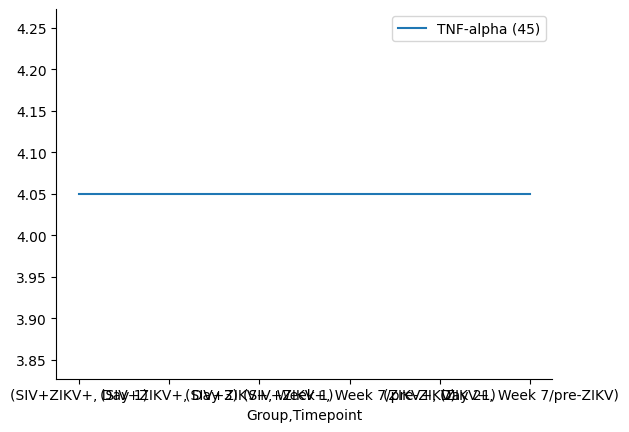

In [ ]:
grouped_data['TNF-alpha (45)'].plot(legend=True)
plt.show()